In [ ]:
# authors : Marianne Reboul, Eun Seo Jo, David McClure

In [101]:
import os
from gensim.models.word2vec import Word2Vec
from collections import OrderedDict, defaultdict
from sklearn.cluster import KMeans
import pandas as pd
import pickle
import sys
import itertools
from sklearn import decomposition as dec
import pandas as pd
from IPython.display import Markdown, display
pd.set_option('display.max_rows', 1000)
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import chain
import math
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline

In [102]:
#1800-1940
def generate_models(root_path):
    models = OrderedDict([
        (year, Word2Vec.load(root_path+"/{}.bin".format(year)))
        for year in range(1840, 1940, 20)
    ])
    return models

In [103]:
#returns a dict {year: list_of_vocab}
def generate_vocab(models):
    all_vocab = {}
    for year, model in models.items():
        all_vocab[year] = [k for k,v in model.wv.vocab.items()]
    return all_vocab

In [104]:
# for each year you get each vector
def generate_matrix(vocab, models):
    all_vectors = {}
    lit_esth_indices = {}
    word_index = {}
    for year, model in models.items():
        mat, lit, esth, word_index_dict = single_matrix(vocab[year], model)
        all_vectors[year] = mat
        lit_esth_indices[year] = (lit, esth)
        word_index[year] = word_index_dict
    return all_vectors, lit_esth_indices, word_index

In [105]:
def single_matrix(vocab, model):
    vec = []
    lit = 'philosophie'
    esth = 'science'
    lit_index = 0
    esth_index = 0
    word_index_dict = {}
    for i, word in enumerate(vocab):
        if word == lit:
            lit_index = i
        elif word == esth:
            esth_index = i
        word_index_dict[i] = word
        vec.append(model.wv[word])
    return np.array(vec), lit_index, esth_index, word_index_dict

In [106]:
def get_clusters(mat_dict, n_clusters):
    cluster_labels = {}
    for year, matrix in mat_dict.items():
        kmeans = (k_means(matrix, n_clusters))
        print (kmeans)
        cluster_labels[year] = kmeans
    return cluster_labels

In [107]:
#builds a matrix within which each number is the cluster index of a word
#number of clusters not relative (bugs) to the size of the map
def k_means(mat, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(mat)
    return kmeans

In [108]:
def match_label_vocab(cluster_labels, vocab):
    word_clusters = {}
    for year, words in vocab.items():
        dup_list = []
        for dup in sorted(list_duplicates(cluster_labels[year])):
            #print (dup)
            dup_list.append(dup[1])
        word_clusters[year] = match(words, dup_list)
    return word_clusters

In [109]:
def match(words, list_index):
    list_words = []
    for i in range(len(list_index)):
        inner_loop = []
        for j in range(len(list_index[i])):
            inner_loop.append(words[list_index[i][j]])
        list_words.append(inner_loop)
    return list_words

In [110]:
def list_duplicates(seq):
    tally = defaultdict(list)
    #knn_clust=bytearray(seq)
    for i,item in enumerate(seq):
        tally[item].append(i)
    return ((key,locs) for key,locs in tally.items()
                            if len(locs)>1)

In [111]:
def generate_clust_to_word(vocabs, labels):
    word_clust_ind=dict()
    for year in labels :
        word_label=defaultdict(list)
        for idx,label in enumerate(labels[year]):
            word_label[label].append(vocabs[year][idx])
        word_clust_ind[year]=dict(word_label)
    return word_clust_ind

In [112]:
def generate_word_to_clust(vocabs, labels):
    word_clust_ind=dict()
    for year in labels :
        word_label=dict()
        for idx,voc in enumerate(vocabs[year]):
            word_label[voc]=labels[year][idx]
        word_clust_ind[year]=word_label
    return word_clust_ind

In [113]:
def tuples_creation (vocab_clusters):
    year_tuples=dict()
    for year in vocab_clusters.keys():
        list_of_lists=list()
        for cluster in vocab_clusters[year]:
            tuples=list(itertools.combinations(cluster, 2))
            list_of_lists.append(tuples)
        year_tuples[year]=list_of_lists
    return year_tuples

In [114]:
def build_PCA(matrix_dict):
    trans_pca=dict()
    for k,v in matrix_dict.items():
        pca = dec.PCA(n_components=2)
        pca.fit(v)
        matrix_dict=pca.transform(v)
        trans_pca[k]=matrix_dict
    return trans_pca

In [115]:
def plot_coord(trans_pca):
    plot_mat=dict()
    for k,v in trans_pca.items():
        coords=np.split(v,2, axis=1)
        #coords=[v[:,0],v[:,1]]
        plot_mat[k]=coords
    return plot_mat

# Création des matrices
Ici on crée les matrices vectorielles qui regroupent les vecteurs proches les uns des autres. Il est possible de déterminer le nombre de noyaux que nous recherchons. Plus il y a de noyaux, plus il y a de chances que les termes recherchés soient dans des noyaux différents.

In [116]:
# Run this cell only if you want to rerun the calculations. If not, go to next
lem_path = "./models/crit"
clusters = 100
models = generate_models(lem_path)
vocabs = generate_vocab(models)
matrix_dict, lit_esth_indices, word_index = generate_matrix(vocabs, models)
labels = get_clusters(matrix_dict, clusters)
vocab_clusters = match_label_vocab(labels, vocabs)
word_and_clust_idx=generate_word_to_clust(vocabs, labels)
pickle.dump(matrix_dict,open("./saved_pickles/french/matrix_dict_phil_sci_100","wb"))
pickle.dump(word_index,open("./saved_pickles/french/word_index_phil_sci_100","wb"))
pickle.dump(lit_esth_indices,open("./saved_pickles/french/lit_phil_sci_100","wb"))
pickle.dump(word_and_clust_idx, open("./saved_pickles/french/word_and_clust_idx_phil_sci_100","wb"))
pickle.dump(vocabs, open("./saved_pickles/french/vocabs_phil_sci_100", "wb"))
pickle.dump(vocab_clusters, open("./saved_pickles/french/vocab_clusters_phil_sci_100", "wb"))
pickle.dump(labels, open("./saved_pickles/french/labels_phil_sci_100", "wb"))
pickle.dump(models, open("./saved_pickles/french/models_phil_sci_100", "wb"))

[61 16 16 ... 94 94  0]
[54 77 77 ... 66 43 77]
[ 0 10  0 ...  0 10  0]
[21  0  0 ... 35 13 13]
[22 22  1 ... 26 22 22]


In [16]:
matrix_dict=pickle.load(open("./saved_pickles/french/matrix_dict_sci","rb"))
word_index=pickle.load(open("./saved_pickles/french/word_index_sci","rb"))
lit_esth_indices=pickle.load(open("./saved_pickles/french/lit_sci_indices","rb"))
vocabs=pickle.load(open( "./saved_pickles/french/vocabs_sci", "rb"))
vocab_clusters=pickle.load(open( "./saved_pickles/french/vocab_clusters_sci", "rb"))
models=pickle.load(open( "./saved_pickles/french/models_sci", "rb"))
labels=pickle.load(open("./saved_pickles/french/labels_sci", "rb"))
word_and_clust_idx=pickle.load(open("./saved_pickles/french/word_and_clust_idx_sci", "rb"))

In [117]:
def union_neighbor_vocab(anchor, topn=200):
    
    vocab = set()
    
    for year, model in models.items():
        similar = model.most_similar(anchor, topn=topn)
        vocab.update([s[0] for s in similar])
        
    return vocab

In [118]:
def lin_reg(series):

    x = np.array(list(series.keys()))
    y = np.array(list(series.values()))

    x = sm.add_constant(x)

    return sm.OLS(y, x).fit()

In [119]:
def cosine_series(anchor, query):
    
    series = OrderedDict()
    
    for year, model in models.items():   
        
        if query in model:
            series[year]=model.similarity(anchor, query)
        else:
            series[year]=0
        

    return series

In [120]:
def plot_cosine_series(anchor, query, w=8, h=4):
    
    series = cosine_series(anchor, query)
    
    fit = lin_reg(series)

    x1 = list(series.keys())[0]
    x2 = list(series.keys())[-1]

    y1 = fit.predict()[0]
    y2 = fit.predict()[-1]
    
    print(query)
    
    plt.figure(figsize=(w, h))
    plt.ylim(0, 1)
    plt.title(query)
    plt.xlabel('Year')
    plt.ylabel('Clustering')
    plt.plot(list(series.keys()), list(series.values()))
    plt.plot([x1, x2], [y1, y2], color='gray', linewidth=0.5)
    plt.show()

# Premier graphe : isoler X et Y
Grâce à cette fonction, nous isolons les deux termes recherchés (par défaut littérature et science), et nous voyons leur évolution dans le temps.

In [121]:
def history_literature_id_graph():
    trans_pca=build_PCA(matrix_dict)
    coords=plot_coord(trans_pca)
    for k, v in sorted(coords.items()):
        indices = lit_esth_indices[k]
        plt.figure(figsize=(8, 4))
        plt.scatter(v[0][indices[0]], v[1][indices[0]], s=10,edgecolor='r',c='r')  #red for literature
        plt.scatter(v[0][indices[1]], v[1][indices[1]], s=30,edgecolor='b',c='b')  #blue for history
        plt.scatter(v[0],v[1],s=0.01,c='0.1')
        plt.title(str(k))
        plt.savefig(str(k)+"_identified")
        plt.show()

# Deuxième graphe : voir à quels noyaux X et Y appartiennent
Grâce à cette fonction, nous voyons quels sont les termes qui apparaissent à chaque cluster, et s'ils appartiennent au cluster de X ou de Y ou les deux.

In [122]:
def cluster_colored_graph():
    trans_pca=build_PCA(matrix_dict)
    coords=plot_coord(trans_pca)
    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0,1,100)]
    for k, v in coords.items():
        indices = lit_esth_indices[k]
        plt.figure(figsize=(32, 16))
        for i in sorted(range(len(v[0]))):
            word = word_index[k][i]
            cluster = word_and_clust_idx[k][word]
            if cluster == word_and_clust_idx[k]["philosophie"] or cluster == word_and_clust_idx[k]["science"]:
                if word_and_clust_idx[k]["philosophie"] == word_and_clust_idx[k]["science"] and cluster == word_and_clust_idx[k]["philosophie"]:
                    plt.scatter(v[0][i],v[1][i],s=30,edgecolor="g", marker="d",c="g")
                    plt.annotate(word, (v[0][i],v[1][i]))
                else:
                    if cluster == word_and_clust_idx[k]["philosophie"]:
                        plt.scatter(v[0][i],v[1][i],s=30,edgecolor="r", marker="X",c="r")
                        plt.annotate(word, (v[0][i],v[1][i]))
                    if cluster == word_and_clust_idx[k]["science"]:
                        plt.scatter(v[0][i],v[1][i],s=30,edgecolor="b", marker="^",c="b")
                        plt.annotate(word, (v[0][i],v[1][i]))
            else:
                plt.scatter(v[0][i],v[1][i],s=1,edgecolor=colors[cluster], c=colors[cluster])
        plt.title(str(k))
        color_lit = colors[word_and_clust_idx[k]["philosophie"]]
        color_sci = colors[word_and_clust_idx[k]["science"]]
        plt.scatter(v[0][indices[0]], v[1][indices[0]], s=50,edgecolor="r", c="r")  #red for literature
        plt.scatter(v[0][indices[1]], v[1][indices[1]], s=50,edgecolor="b", c="b") 
        plt.savefig(str(k)+"_phil_sci_clustered100")
        plt.show()

In [99]:
testList = ('littérature','poésie', 'science', 'savoir', 'histoire', 'philosophie', 'lettre', 'critique', 
            'roman', 'théâtre', 'drame', 'esprit', 'langue', 'politique', 'morale', 'société', 
            'pouvoir', 'théologie', 'droit', 'loi', 'méthode', 'génie')

word_searched='littérature'

for key,array in sorted(vocab_clusters.items()) :
    for words in array:
        if word_searched in words:
            #print("Pour l'année "+str(key)+", les clusters :")
            msg = repr([x for x in words])
            #print (msg+'\n')

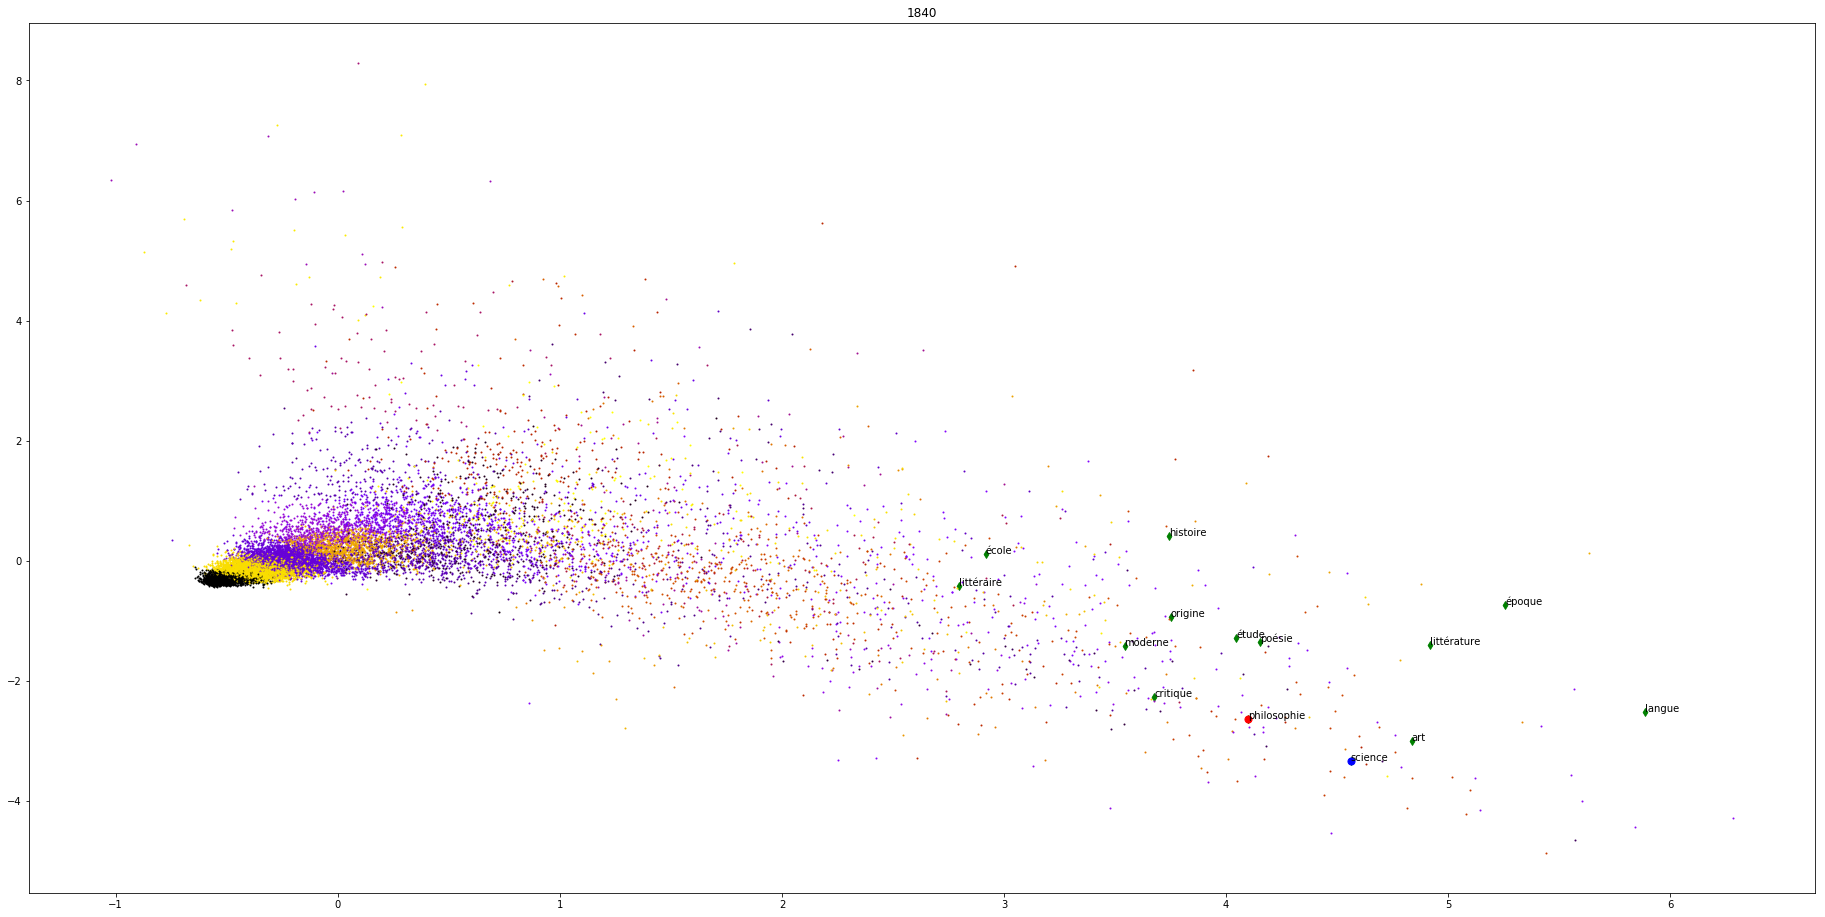

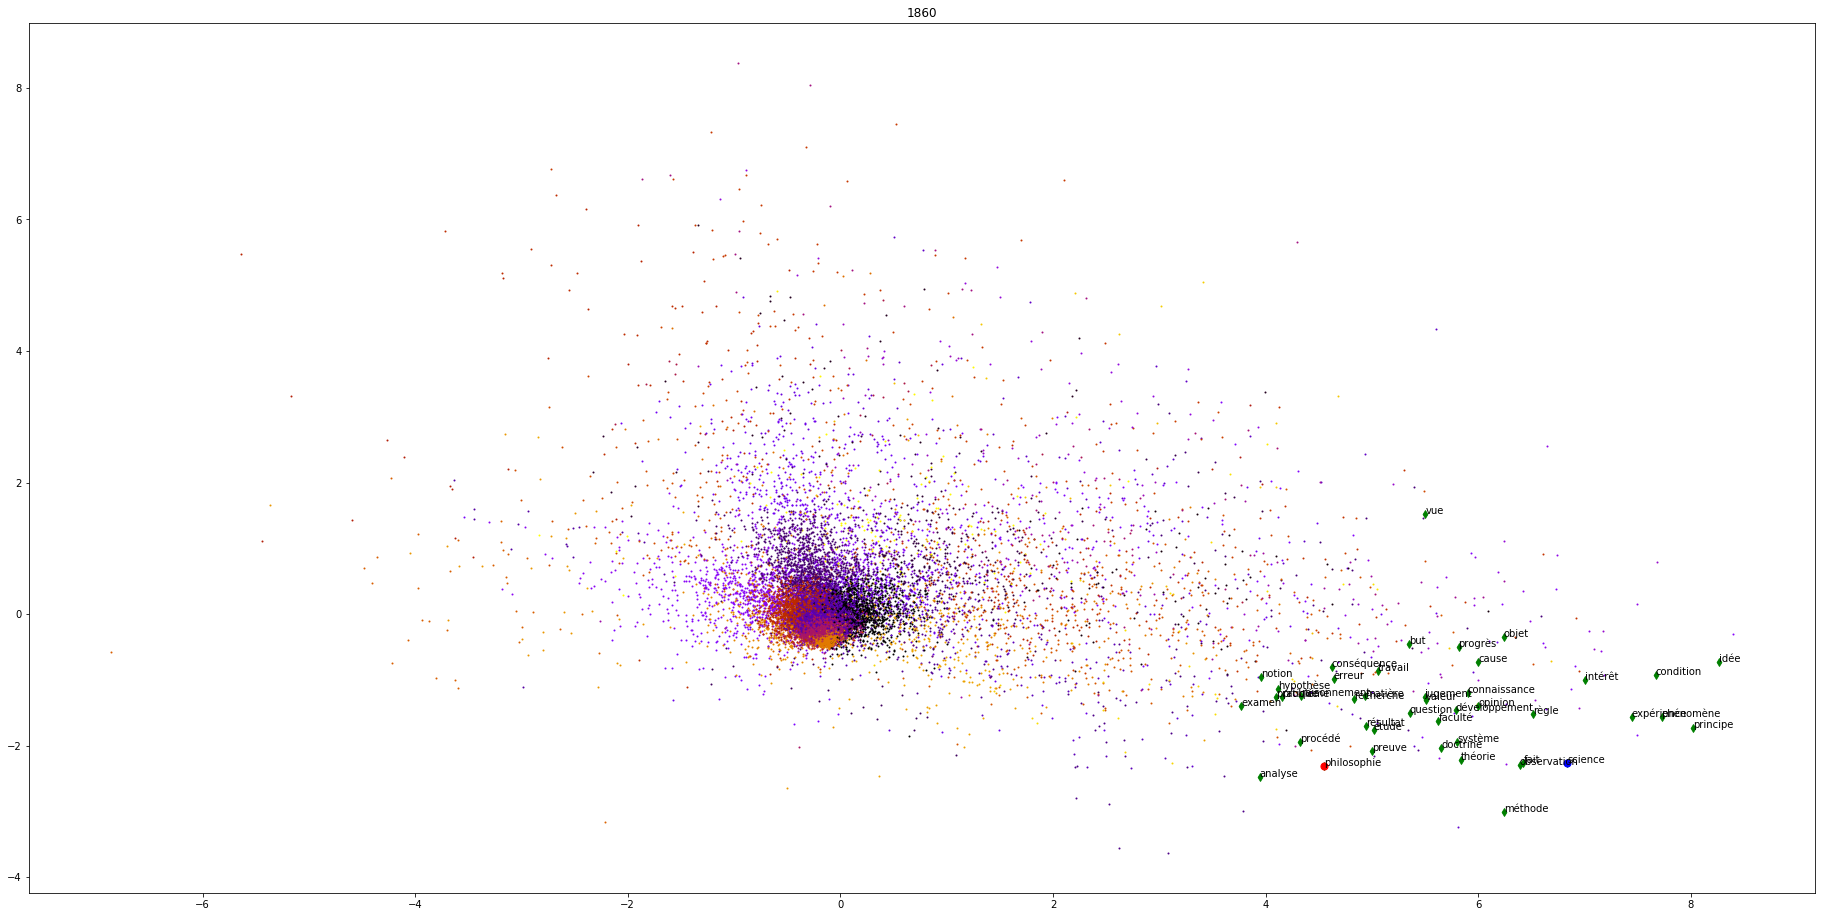

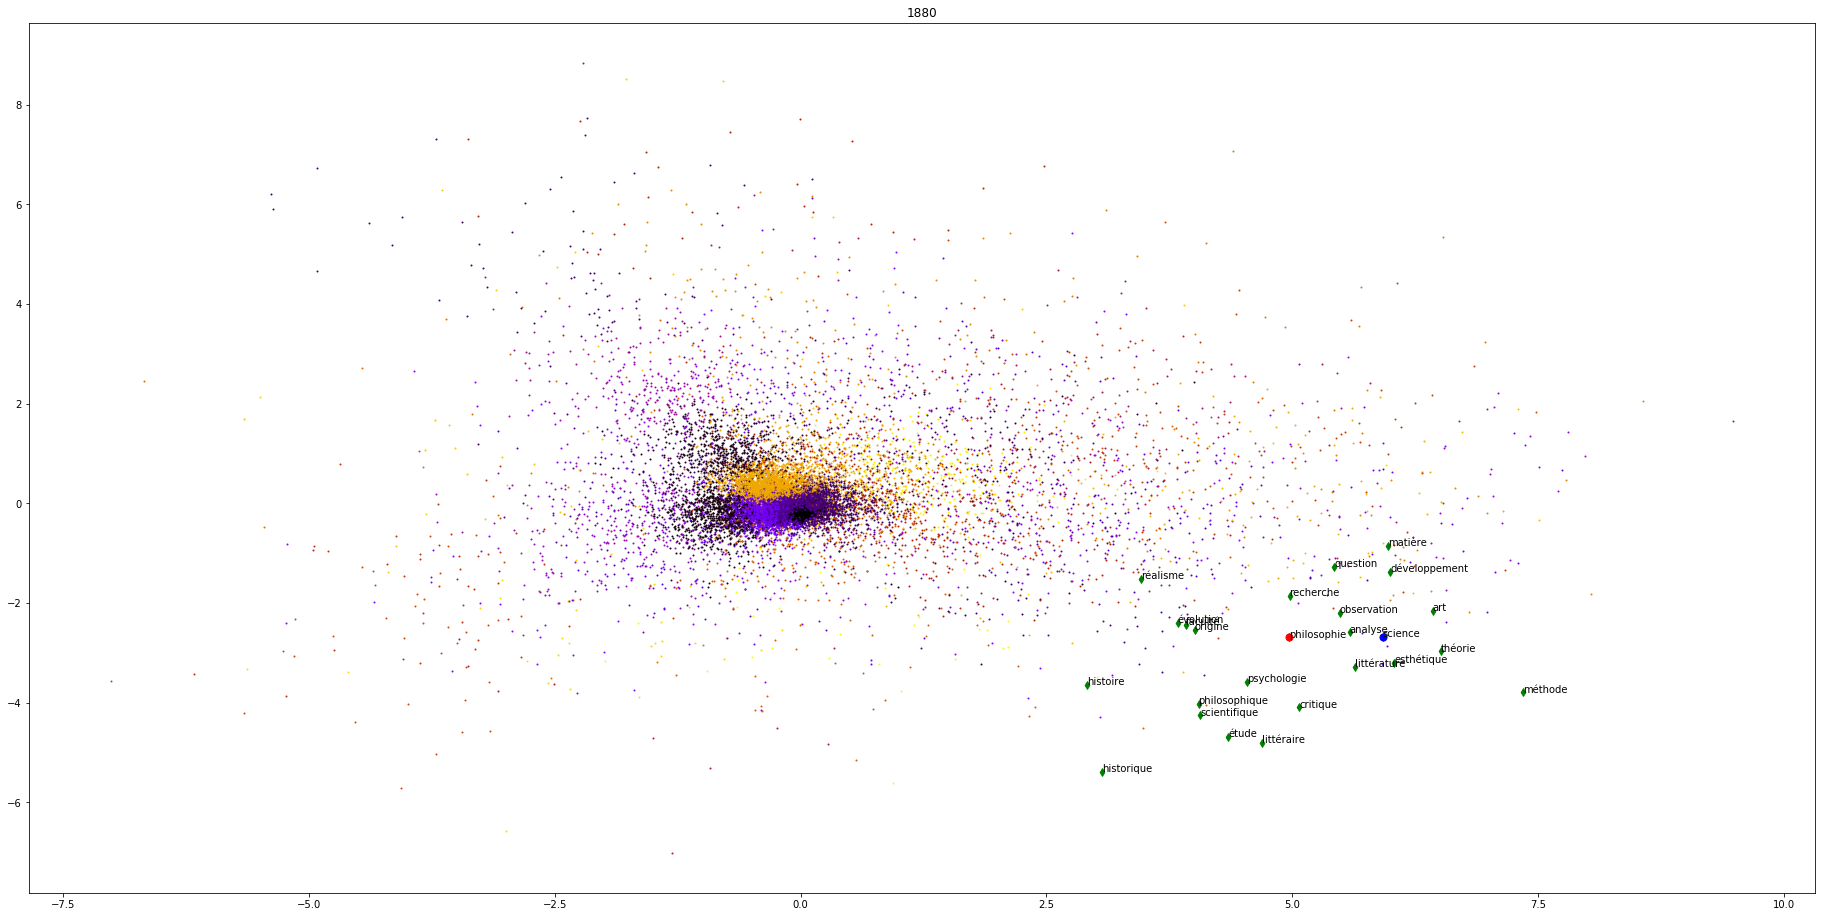

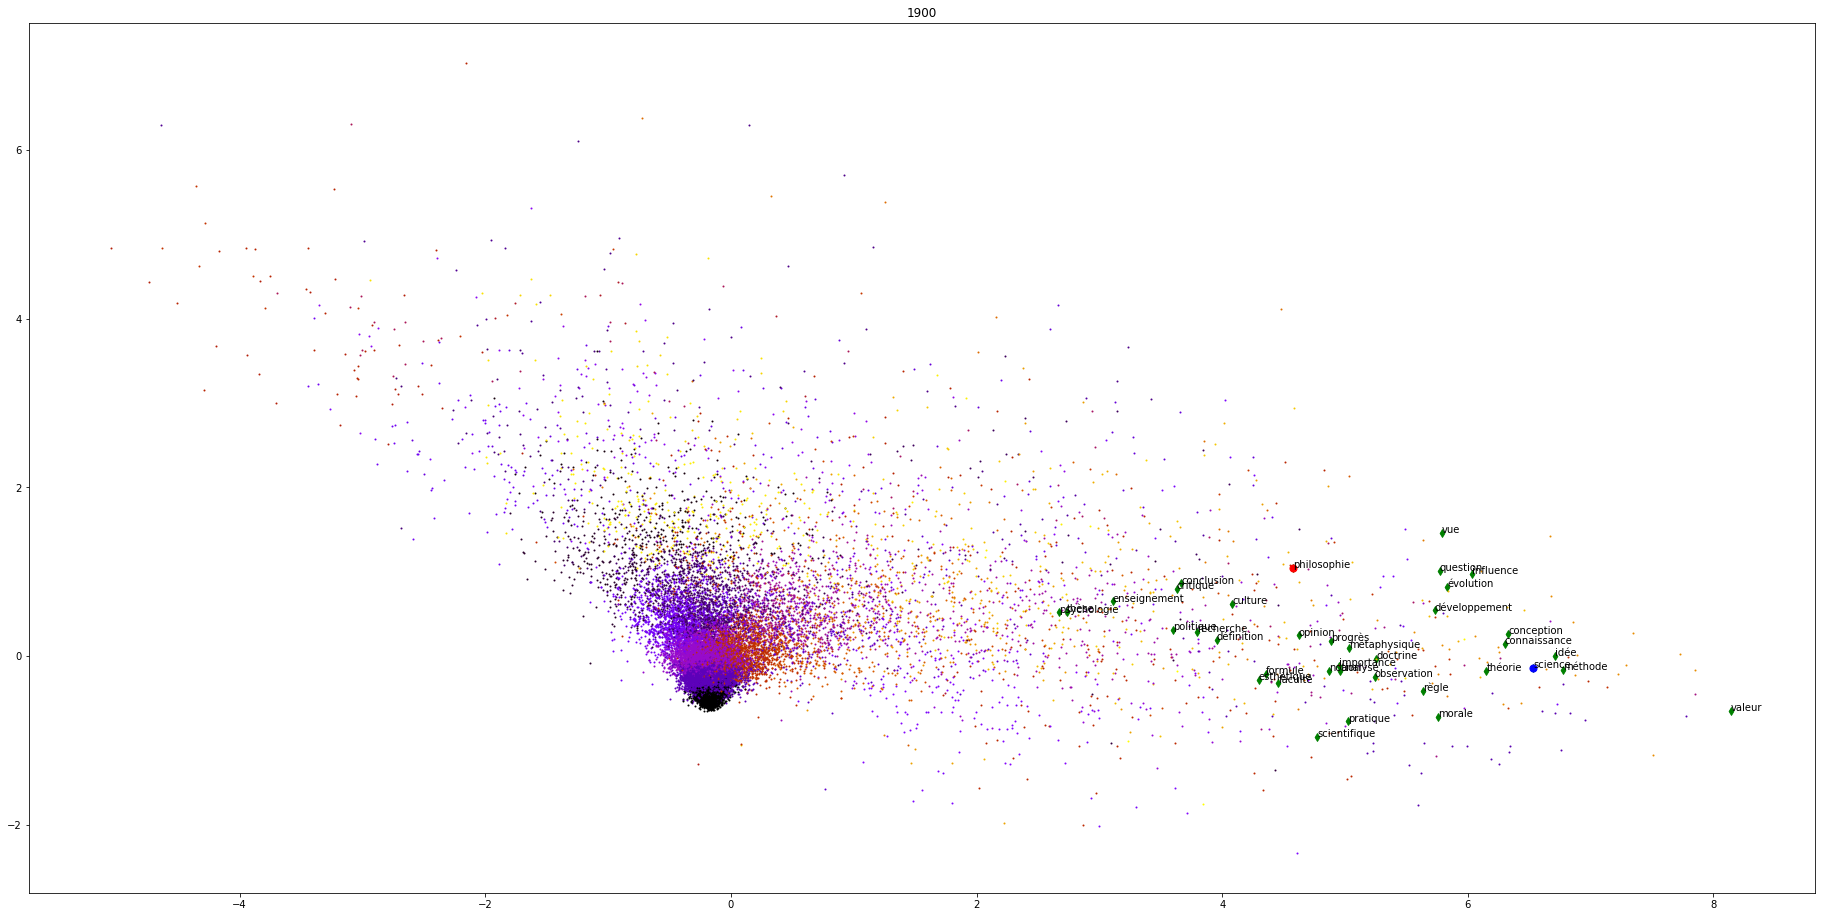

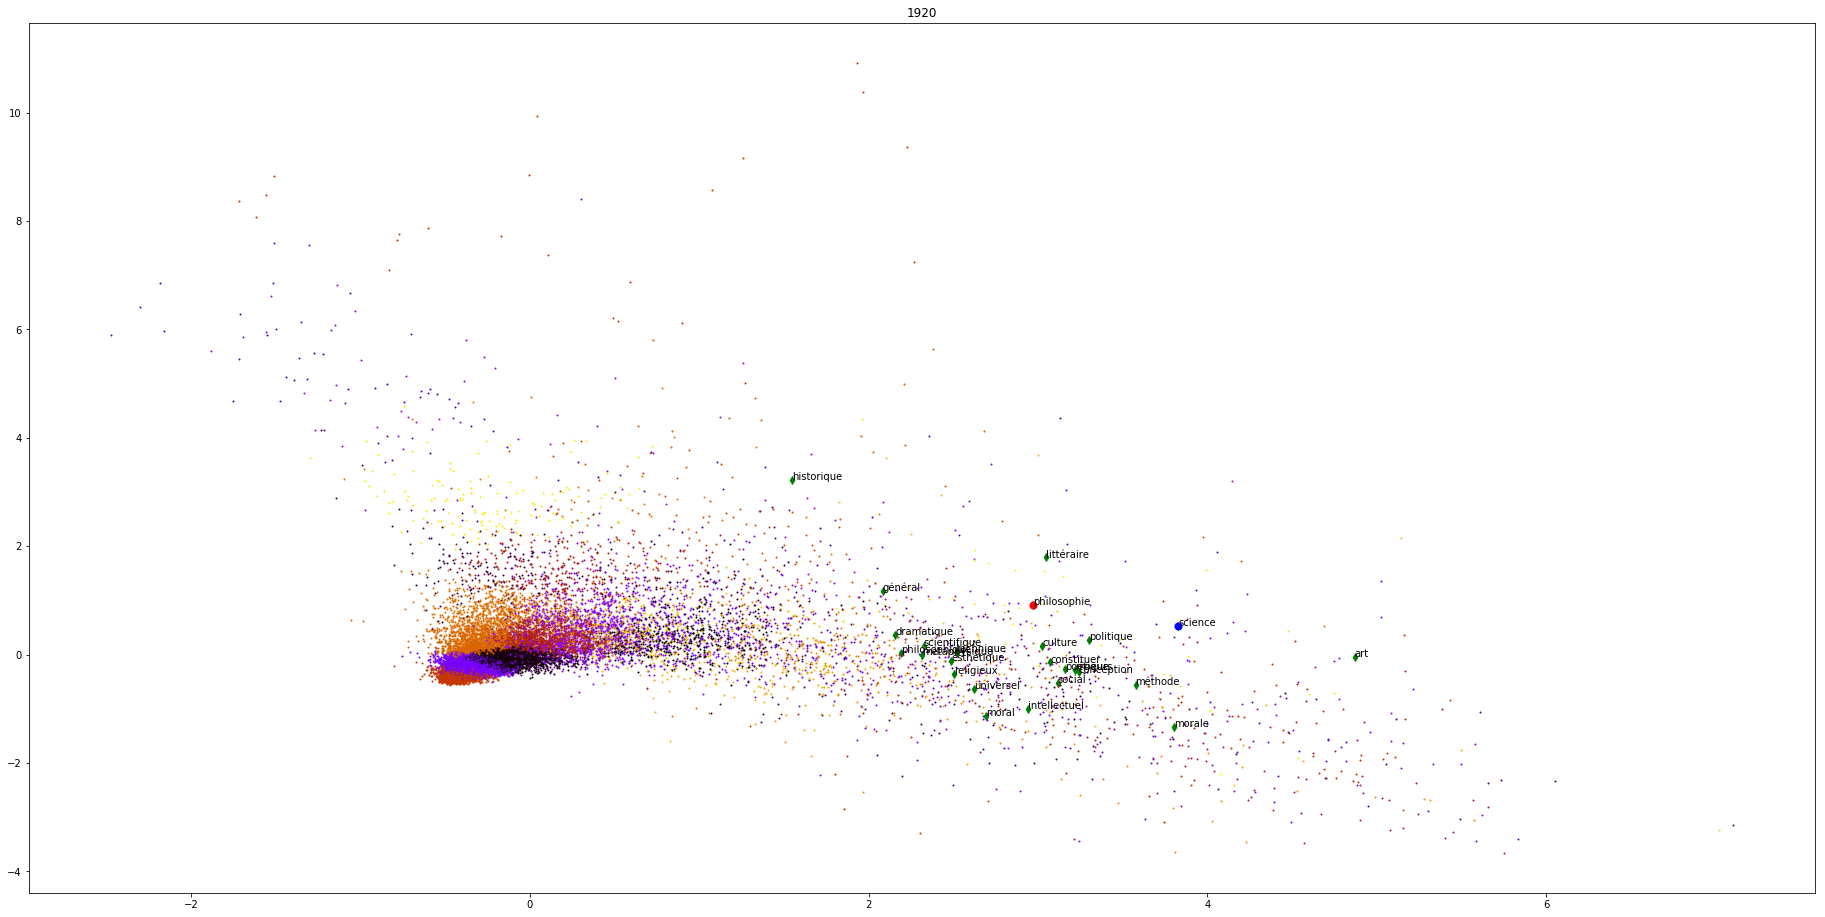

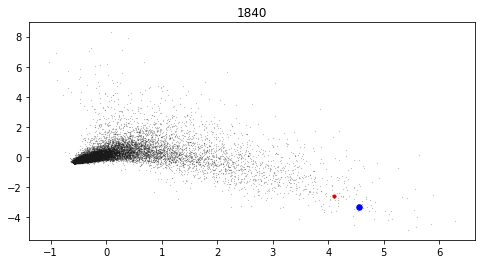

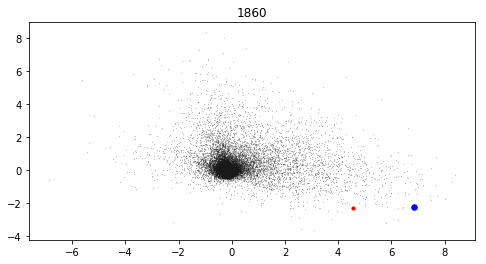

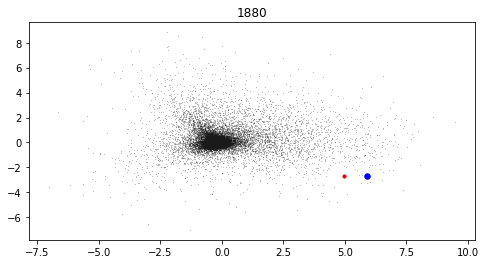

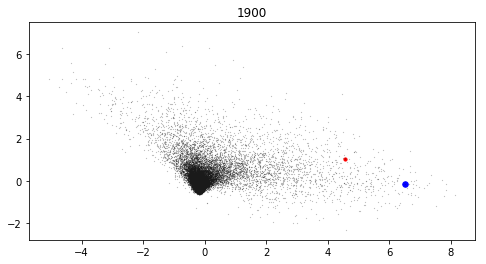

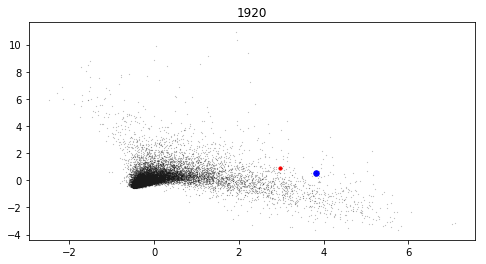

/home/odysseus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/home/odysseus/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/home/odysseus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/home/odysseus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


In [123]:
entries={}

cluster_colored_graph()
history_literature_id_graph()

word_searched='littérature'

data_cos = []
for token in union_neighbor_vocab(word_searched):
    
    series = cosine_series(word_searched, token)
    fit = lin_reg(series)
    
    if fit.pvalues[1] < 0.05:
        data_cos.append((token, fit.params[1], fit.pvalues[1]))
entries[word_searched]=data_cos

In [ ]:
plot_cosine_series('littérature', 'philosophie')

In [ ]:
def intersect_neighbor_vocab(anchor, topn=2000):
    
    vocabs_vec = []
    
    for year, model in models.items():
        similar = model.most_similar(anchor, topn=topn)
        vocabs_vec.append(set([s[0] for s in similar]))
        
    return set.intersection(*vocabs_vec)

In [ ]:
entries={}
data_cos = []
for token in intersect_neighbor_vocab(word_searched):
    
    series = cosine_series(word_searched, token)
    fit = lin_reg(series)
    
    if fit.pvalues[1] < 0.05:
        data_cos.append((token, fit.params[1], fit.pvalues[1]))
entries[word_searched]=data_cos

In [ ]:
display(Markdown("### <i><b>"+word_searched+"</i></b>"))
df3 = pd.DataFrame(entries[word_searched], columns=('token', 'slope', 'p'))
print(df3.sort_values('slope', ascending=False).head(20))
print('\n\n')
    
for i, row in df3.sort_values('slope', ascending=False).head(10).iterrows():
    plot_cosine_series(word_searched, row['token'], 8, 4)